In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
from collections import defaultdict
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

from tqdm import tqdm

# model
import lightgbm as lgb

SEED=42
LABEL=None

In [0]:
path = '/content/drive/My Drive/bigcontest2019/'
os.chdir(path)

In [0]:
train_activity = pd.read_csv('data/train/train_activity.csv')
train_combat = pd.read_csv('data/train/train_combat.csv')
train_payment = pd.read_csv('data/train/train_payment.csv')
train_pledge = pd.read_csv('data/train/train_pledge.csv')
train_trade = pd.read_csv('data/train/train_trade.csv')

test1_activity = pd.read_csv('data/test/test1_activity.csv')
test1_combat = pd.read_csv('data/test/test1_combat.csv')
test1_payment = pd.read_csv('data/test/test1_payment.csv')
test1_pledge = pd.read_csv('data/test/test1_pledge.csv')
test1_trade = pd.read_csv('data/test/test1_trade.csv')

test2_activity = pd.read_csv(path + 'data/test/test2_activity.csv')
test2_combat = pd.read_csv(path + 'data/test/test2_combat.csv')
test2_payment = pd.read_csv(path + 'data/test/test2_payment.csv')
test2_pledge = pd.read_csv(path + 'data/test/test2_pledge.csv')
test2_trade = pd.read_csv(path + 'data/test/test2_trade.csv')

train_label = pd.read_csv('data/train/train_label.csv')

In [0]:
class data_transform(object):
    def __init__(self, data):
        self.data = data
        
    def create_week(self):
        self.data['week'] = (self.data['day']-1)//7 + 1
        return self.data
    
    def activity_transform(self):
        temp_df = self.data
        groupby_dict = defaultdict()
        
        temp_df = pd.get_dummies(temp_df)
        
        for feature in temp_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day' or feature == 'char_id':
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = 'sum'
        else:        
            temp_df = temp_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
        
        return temp_df
    
    def payment_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day':
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = ['sum', 'count', 'max', 'std']
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        
        return output_df
    
    def trade_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        groupby_dict2 = defaultdict()
        
        output_df['time'] = output_df['time'].apply(lambda x: str(x)[:2])
        output_df[['time', 'type', 'server']] = output_df[['time', 'type', 'server']].astype(object)
        output_df = pd.get_dummies(output_df)
        output_df2 = output_df.copy()
        
        output_df = output_df.rename(columns={'source_acc_id':'acc_id'})
        output_df2 = output_df2.rename(columns={'target_acc_id':'acc_id'})
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'item_type', 'source_char_id', 'target_char_id', 'target_acc_id']:
                groupby_dict[feature] = 'nunique'
            else:
                groupby_dict[feature] = 'sum'
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
        
        for feature in output_df2.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'item_type', 'source_char_id', 'target_char_id', 'source_acc_id']:
                groupby_dict2[feature] = 'nunique'
            else:
                groupby_dict2[feature] = 'sum'
        else:
            output_df2 = output_df2.groupby(['acc_id', 'week']).agg(groupby_dict2).reset_index()
        
        output_df = pd.merge(output_df, output_df2, how='outer', on=['acc_id', 'week'])
        
        return output_df
    
    def combat_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        output_df[['server', 'class', 'level']] = output_df[['server', 'class', 'level']].astype(str)
        output_df = pd.get_dummies(output_df)
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature == 'day':
                groupby_dict[feature] = 'nunique'
            elif feature == 'char_id':
                groupby_dict[feature] = ['nunique', 'size']
            else:
                groupby_dict[feature] = ['sum']
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        
        return output_df
    
    def pledge_transform(self):
        output_df = self.data
        groupby_dict = defaultdict()
        
        output_df[['server']] = output_df[['server']].astype(str)
        output_df = pd.get_dummies(output_df)
        
        for feature in output_df.columns:
            if feature == 'acc_id' or feature == 'week':
                pass
            elif feature in ['day', 'pledge_id']:
                groupby_dict[feature] = 'nunique'
            elif feature == 'char_id':
                groupby_dict[feature] = ['nunique', 'size']
            else:
                groupby_dict[feature] = 'sum'
        else:
            output_df = output_df.groupby(['acc_id', 'week']).agg(groupby_dict).reset_index()
            output_df.columns = [i+j for i,j in output_df.columns.ravel()]
        return output_df
    
    
    
    def under_sampling(self):
        temp_df = self.data
        output_df = pd.DataFrame()
        for week in [1, 2, 3, 4]:
            _, under_sample = train_test_split(temp_df[(temp_df['week']==week) & (temp_df['survival_time']==64)], test_size=0.001, random_state=42, shuffle=True, 
                                               stratify=temp_df.loc[(temp_df['week']==week) & (temp_df['survival_time']==64), 'day'])
            output_df = pd.concat([output_df, under_sample]).reset_index(drop=True)
        
        return output_df
    
    def under_sampling2(self):
        temp_df = self.data
        _, under_sample = train_test_split(temp_df[(temp_df['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True)
#                                            stratify=temp_df.loc[(temp_df['survival_time']==64), 'daynunique'])
        
        return under_sample

# survival time

## train

### acitivity

In [0]:
transform = data_transform(train_activity)
transform.create_week()
train = transform.activity_transform()

### payment

In [0]:
transform = data_transform(train_payment)
transform.create_week()
train = transform.payment_transform()

### trade

In [0]:
trandform = data_transform(train_trade)
trandform.create_week()
train = trandform.trade_transform()

### combat

In [0]:
trandform = data_transform(train_combat)
trandform.create_week()
train = trandform.combat_transform()

### pledge

In [0]:
trandform = data_transform(train_pledge)
trandform.create_week()
train = trandform.pledge_transform()

## test

### activity

In [0]:
transform = data_transform(test1_activity)
transform.create_week()
test1 = transform.activity_transform()

transform = data_transform(test2_activity)
transform.create_week()
test2 = transform.activity_transform()

### payment

In [0]:
transform = data_transform(test1_payment)
transform.create_week()
test1 = transform.payment_transform()

transform = data_transform(test2_payment)
transform.create_week()
test2 = transform.payment_transform()

### trade

In [0]:
trandform = data_transform(test1_trade)
trandform.create_week()
test1 = trandform.trade_transform()

trandform = data_transform(test2_trade)
trandform.create_week()
test2 = trandform.trade_transform()

### combat

In [0]:
trandform = data_transform(test1_combat)
trandform.create_week()
test1 = trandform.combat_transform()

trandform = data_transform(test2_combat)
trandform.create_week()
test2 = trandform.combat_transform()

### pledge

In [0]:
trandform = data_transform(test1_pledge)
trandform.create_week()
test1 = trandform.pledge_transform()

trandform = data_transform(test2_pledge)
trandform.create_week()
test2 = trandform.pledge_transform()

## model

In [0]:
class model(object):
    def __init__(self, train_data, train_label, test1_data, test2_data, kind):
        self.train_data = train_data.fillna(0)
        self.train_label = train_label
        self.test1_data = test1_data.fillna(0)
        self.test2_data = test2_data.fillna(0)
        self.features_ = train_data[list(set(train_data.columns) & set(test1_data.columns) & set(test2_data.columns))].drop(columns=['acc_id', 'week']).columns
        self.kind = kind
        self.lgb_model_st = defaultdict()
        
    def labeling(self):
        self.train_data = pd.merge(self.train_data, self.train_label[['acc_id', 'survival_time']], how='left', on='acc_id').dropna().reset_index(drop=True)
        for week in range(1, 5):
            self.train_data.loc[self.train_data['week']==week, 'survival_time'] = np.minimum(64, self.train_data.loc[self.train_data['week']==week, 'survival_time'] + 7*(4-week))
        
    def under_sampling(self, data):
        all_week_under_sample = pd.DataFrame()
        
        for week in range(1, 5):
            if self.kind == 'activity':
                _, under_sample = train_test_split(self.train_data[(self.train_data['week']==week) & (self.train_data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True, 
                                                   stratify=self.train_data.loc[(self.train_data['week']==week) & (self.train_data['survival_time']==64), 'day'])
            elif self.kind == 'payment':
                _, under_sample = train_test_split(self.train_data[(self.train_data['week']==week) & (self.train_data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True)
                
            elif self.kind == 'trade':
                _, under_sample = train_test_split(self.train_data[(self.train_data['week']==week) & (self.train_data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True)

            elif self.kind == 'combat':
                _, under_sample = train_test_split(self.train_data[(self.train_data['week']==week) & (self.train_data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True,
                                                  stratify=self.train_data.loc[(self.train_data['week']==week) & (self.train_data['survival_time']==64), 'daynunique'])
            elif self.kind == 'pledge':
                _, under_sample = train_test_split(self.train_data[(self.train_data['week']==week) & (self.train_data['survival_time']==64)], test_size=0.01, random_state=42, shuffle=True,
                                                  stratify=self.train_data.loc[(self.train_data['week']==week) & (self.train_data['survival_time']==64), 'daynunique'])
                
            all_week_under_sample = pd.concat([all_week_under_sample, under_sample])
        else:
            self.train_data = pd.concat([self.train_data[self.train_data['survival_time']!=64], all_week_under_sample]).reset_index(drop=True)
            
    def lgb_train_st(self, params, iteration, seed):
        LABEL='survival_time'
        skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

        for idx, (trn_idx, val_idx) in enumerate(skf.split(self.train_data, self.train_data[LABEL])):
            
            # under_sampling(self.train_data)
            
            trn_label = self.train_data.loc[trn_idx, LABEL] - 1
            val_label = self.train_data.loc[val_idx, LABEL] - 1
            train_df = lgb.Dataset(self.train_data.loc[trn_idx, self.features_], label=trn_label)
            valid_df = lgb.Dataset(self.train_data.loc[val_idx, self.features_], label=val_label)
            
            lgb_model = lgb.train(params, train_df, iteration, valid_sets = [train_df, valid_df], early_stopping_rounds = 50, verbose_eval=100)
            self.lgb_model_st['model'+str(idx)] = lgb_model
    
    def feature_importance(self):
        feature_imp = pd.DataFrame(sorted(zip(self.st_lgb_model.feature_importance(), self.features_)), columns=['Value','Feature'])
        plt.figure(figsize=(20, 10))
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.show()
    
    def infer_oof(self):
        LABEL='survival_time'
        oof = np.zeros(len(self.train_data))
        skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

        for idx, (_, val_idx) in enumerate(skf.split(self.train_data, self.train_data[LABEL])):
            oof[val_idx] = np.argmax(self.lgb_model_st['model'+str(idx)].predict(self.train_data.loc[val_idx, self.features_]), axis=1)+1
        else:
            oof = pd.concat([self.train_data, pd.DataFrame(oof, columns=['infer_survival_time'])], 1)
            oof = oof.loc[oof['week']==4, ['acc_id', 'survival_time', 'infer_survival_time']].reset_index(drop=True)
        return oof
        
    def load(self, return_data):
        
        if return_data=='train':
            return self.train_data
        elif retrun_data=='model':
            return self.lgb_model_st

In [0]:
PARAMS = {
    'objective':'multiclass',
    'num_class':64,
    "boosting": "gbdt",
    'learning_rate': 0.03,
    'subsample' : 0.6,
    'sumsample_freq':1,
    'colsample_bytree':0.221856,
    'max_depth': 16,
    'max_bin':255,
    "lambda_l1": 0.25,
    "lambda_l2": 1,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split':0.02,
    'min_data_in_bin':3,
    'bin_construct_sample_cnt':5000,
    'cat_l2':10,
    'verbose':-1,
    'nthread':-1,
    'seed':SEED
}

# 주의!! model object 마지막 kinds arguments 명시해줄것!!
TYPE='combat'

model_ = model(train, train_label, test1, test2, TYPE)
model_.labeling()
model_.lgb_train_st(PARAMS, 5000, SEED)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 1.87071	valid_1's multi_logloss: 1.98154
[200]	training's multi_logloss: 1.73903	valid_1's multi_logloss: 1.93816
[300]	training's multi_logloss: 1.64842	valid_1's multi_logloss: 1.92314
[400]	training's multi_logloss: 1.5773	valid_1's multi_logloss: 1.91741
[500]	training's multi_logloss: 1.51823	valid_1's multi_logloss: 1.91549
Early stopping, best iteration is:
[519]	training's multi_logloss: 1.50808	valid_1's multi_logloss: 1.91533
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 1.86871	valid_1's multi_logloss: 1.9839
[200]	training's multi_logloss: 1.73667	valid_1's multi_logloss: 1.94145
[300]	training's multi_logloss: 1.64592	valid_1's multi_logloss: 1.9275
[400]	training's multi_logloss: 1.5745	valid_1's multi_logloss: 1.92193
[500]	training's multi_logloss: 1.51544	valid_1's multi_logloss: 1.92005
Early stopping, best iteration is:
[543]	t

In [0]:
oof = model_.infer_oof()

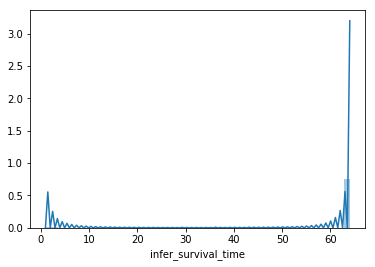

In [0]:
sns.distplot(oof['infer_survival_time'])

In [0]:
oof

,acc_id,survival_time,infer_survival_time
0,2,64,64.0
1,5,60,64.0
2,8,64,64.0
3,17,64,64.0
4,20,64,64.0
5,21,64,64.0
6,31,45,64.0
7,38,64,64.0
8,41,3,3.0
9,43,64,64.0


# amount spent

In [0]:
from sklearn.model_selection import KFold

train_label['amount_spent_round'] = np.round(train_label['amount_spent'], 2)

oof_spent = pd.DataFrame()

# preds_spent1 = defaultdict()
# preds_spent2 = defaultdict()
i=0
kf = KFold(n_splits=5,random_state=42, shuffle=True)

for trn_idx,val_idx in kf.split(train_label):
    stack_oof = pd.DataFrame()
    i+=1
    for SEED in range(1,11):
        stack_df = pd.DataFrame()
        np.random.seed(SEED)

        for as_round in train_label['amount_spent_round'].unique():
            temp_df = train_label[train_label['amount_spent_round']==as_round]
            try:
                idx = np.random.choice(temp_df.index, 3, replace=False)
                temp_df = temp_df.loc[idx]
            except:
                pass
            stack_df = pd.concat([stack_df, temp_df])
        
        idx_lst = stack_df['acc_id']
        
        # stack_preds1 = np.zeros(len(preds_st))
        # stack_preds2 = np.zeros(len(preds_st2))

        train_df = stack_df['survival_time'].reset_index(drop=True)
        label_df = stack_df['amount_spent'].reset_index(drop=True)
        val_df = train_label['survival_time'].reset_index(drop=True)

        rf = RandomForestRegressor(n_estimators=100).fit(train_df.values.reshape(-1,1), label_df.values.ravel())

        stack_oof['val_idx'] = val_idx
        stack_oof['model_'+str(SEED)] = rf.predict(val_df[val_idx].values.reshape(-1,1))

        # stack_preds1 += rf.predict(preds_st['survival_time'].values.reshape(-1,1))/kf.n_splits
        # stack_preds2 += rf.predict(preds_st2['survival_time'].values.reshape(-1,1))/kf.n_splits

        # preds_spent1['model_'+str(i)+str(SEED)] = stack_preds1
        # preds_spent2['model_'+str(i)+str(SEED)] = stack_preds2

    oof_spent = pd.concat([oof_spent,stack_oof],axis=0)

In [0]:
oof_spent = pd.concat([oof_spent,stack_oof],axis=0)

In [0]:
 oof_spent_1 = oof_spent.sort_values(by='val_idx').drop('val_idx',axis=1)

In [0]:
oof_spent_1.describe()

,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,0.885821,0.899214,0.898044,0.894867,0.897362,0.897258,0.925020,0.891045,0.889916,0.912019
std,1.376981,1.403467,1.386998,1.348111,1.382233,1.386760,1.353046,1.406025,1.397178,1.408277
min,0.083753,0.196225,0.114433,0.128054,0.143979,0.137270,0.134149,0.117613,0.072751,0.043401
25%,0.331986,0.330740,0.337399,0.345922,0.329530,0.343177,0.348326,0.317064,0.354790,0.359369
50%,0.331986,0.330740,0.337399,0.345922,0.329530,0.343177,0.348326,0.317064,0.354790,0.359369
75%,0.951103,0.855183,0.883437,0.898084,0.930121,0.857218,1.002572,0.923273,0.885133,0.946655
max,8.140454,8.226225,8.086199,7.867371,8.225830,8.165146,7.958460,8.298256,8.207259,8.362137


# submission

In [0]:
oof

,acc_id,survival_time,infer_survival_time
0,2,64,64.0
1,5,60,64.0
2,8,64,64.0
3,17,64,64.0
4,20,64,64.0
5,21,64,64.0
6,31,45,64.0
7,38,64,64.0
8,41,3,3.0
9,43,64,64.0


In [0]:
test1_pred = pd.concat([test1_week['acc_id'], pd.DataFrame(preds, columns=['survival_time']), pd.DataFrame(preds_spent*25, columns=['amount_spent'])], 1)
test1_pred.to_csv('/content/test1_predict.csv', index=False)

In [0]:
test2_pred = pd.concat([test2_week['acc_id'], pd.DataFrame(preds2, columns=['survival_time']), pd.DataFrame(preds2_spent*10, columns=['amount_spent'])], 1)
test2_pred.to_csv('/content/test2_predict.csv', index=False)

In [0]:
test1_pred = pd.concat([test1[test1['week']==4]['acc_id'].reset_index(drop=True), pd.DataFrame(preds_st, columns=['survival_time']), pd.DataFrame(preds_spent, columns=['amount_spent'])], 1)
test1_pred.to_csv('/content/test1_predict.csv', index=False)

In [0]:
test2_pred = pd.concat([test2[test2['week']==4]['acc_id'].reset_index(drop=True), pd.DataFrame(preds_st2, columns=['survival_time']), pd.DataFrame(preds_spent2, columns=['amount_spent'])], 1)
test2_pred.to_csv('/content/test2_predict.csv', index=False)

In [0]:
lst = []
for i in range(0,64):
    lst.append(30*(np.exp(-0.5*(i**2/15**2))))

In [0]:
lst

[30.0,
 29.933407352568192,
 29.734515014648547,
 29.405960199202656,
 28.952073533690413,
 28.37878406720296,
 27.693490391599074,
 26.904901792406065,
 26.022854195502322,
 25.05810634233816,
 24.022122087504243,
 22.926844955144713,
 21.784471112210728,
 20.607226723721634,
 19.40715526393057,
 18.195919791379,
 16.984624485515926,
 15.783658922803694,
 14.60256767879915,
 13.44994691822829,
 12.333368715215624,
 11.259332965541986,
 10.23324594289776,
 9.259423837098568,
 8.341119013595824,
 7.480566263318886,
 6.679045976366728,
 5.93696097250844,
 5.253923650354529,
 4.62885016504705,
 4.060058497098381,
 3.5453675154534166,
 3.0821944470748304,
 2.6676485237815903,
 2.298618965414805,
 1.9718558584959143,
 1.6840428850240117,
 1.4318612328949245,
 1.2120443662248972,
 1.0214236420379803,
 0.8569650235365113,
 0.7157973563814074,
 0.5952328423311086,
 0.49278046556656635,
 0.4061532040995707,
 0.3332698961472692,
 0.2722526344695468,
 0.2214205361302275,
 0.17928068685017828,
 0.

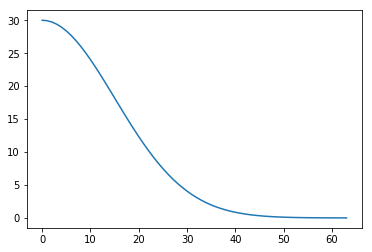

In [0]:
sns.lineplot(x =range(0,64),y=lst)

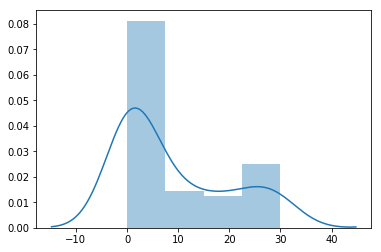

In [0]:
sns.distplot(lst)

In [0]:
0.004432450806961009*30

0.1329735242088303

In [0]:
8.8*0.3

2.64

In [0]:
8/9
# 과소추정을 ~> 얼마까지 해야하는가!!!

1.125

In [0]:
from google.colab import files
 df = files.upload()

IndentationError: ignored

In [0]:
st_df

In [0]:
import io

# as_df = pd.read_csv(io.BytesIO(as_df['oof_as.csv']))
# st_df = pd.read_csv(io.BytesIO(st_df['oof_st.csv']))

st_df = pd.read_csv('/content/oof_st.csv')
as_df = pd.read_csv('/content/oof_as.csv')

In [0]:
st_df.columns
as_df.columns

Index(['acc_id', 'total_amount_spent', 'infer_amount_spent'], dtype='object')

In [0]:
def div(df1,df2):
    return df1/df2

In [0]:
profit_result = []
survival_time_pred = list(st_df.infer_survival_time)
amount_spent_pred = list(div(as_df['infer_amount_spent'],st_df['infer_survival_time']))
survival_time_actual = list(st_df.survival_time)
amount_spent_actual = list(div(as_df['total_amount_spent'],st_df['survival_time']))    

In [0]:
merge_df = pd.merge(st_df,as_df,how='left',on='acc_id')

In [0]:
gamma_lst,T_k_lst,add_rev_lst,cost_lst = [],[],[],[]

S, alpha, L, sigma = 30, 0.01, 0.1, 15  
cost, gamma, add_rev = 0,0,0

In [0]:
for i in range(len(survival_time_pred)):
    if survival_time_pred[i] == 64 :                 
        cost = 0
        optimal_cost = 0
    else:
        cost = alpha * S * amount_spent_pred[i]                    #비용 계산
        optimal_cost = alpha * S * amount_spent_actual[i]          #적정비용 계산 
    
    if optimal_cost == 0:
        gamma = 0
    elif cost / optimal_cost < L:
        gamma = 0
    elif cost / optimal_cost >= 1:
        gamma = 1
    else:
        gamma = (cost)/((1-L)*optimal_cost) - L/(1-L)              #반응률 계산
    
    if survival_time_pred[i] == 64 or survival_time_actual[i] == 64:
        T_k = 0
    else:
        T_k = S * np.exp(-((survival_time_pred[i] - survival_time_actual[i])**2)/(2*(sigma)**2))    #추가 생존기간 계산
        
    add_rev = T_k * amount_spent_actual[i]                         #잔존가치 계산

    gamma_lst.append(gamma)
    T_k_lst.append(T_k)
    add_rev_lst.append(add_rev)
    cost_lst.append(cost)

In [0]:
metrics = pd.concat([merge_df,pd.DataFrame({'gamma':gamma_lst,'add_rev':add_rev_lst,'cost':cost_lst})],axis=1)

In [0]:
metrics[metrics['gamma'] ==0]

,acc_id,survival_time,infer_survival_time,total_amount_spent,infer_amount_spent,gamma,add_rev,cost
0,2,64,64.0,0.000000,0.008169,0.0,0.000000,0.000000
1,5,60,40.0,0.000000,0.085223,0.0,0.000000,0.000639
3,17,64,59.0,2.543119,0.084563,0.0,0.000000,0.000430
4,20,64,64.0,1.876923,0.158019,0.0,0.000000,0.000000
5,21,64,9.0,6.633607,0.092194,0.0,0.000000,0.003073
6,31,45,36.0,1.847393,0.053760,0.0,1.028715,0.000448
7,38,64,36.0,18.618039,0.145668,0.0,0.000000,0.001214
8,41,3,3.0,0.000000,0.073199,0.0,0.000000,0.007320
9,43,64,22.0,12.823083,0.061011,0.0,0.000000,0.000832
10,50,64,64.0,0.000000,0.036535,0.0,0.000000,0.000000


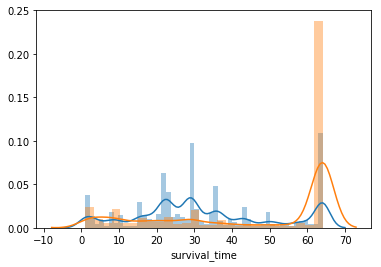

In [0]:
# metrics[metrics['gamma']>0]
sns.distplot(metrics['infer_survival_time'])
sns.distplot(metrics['survival_time'])

In [0]:
len(metrics[metrics['gamma']==0])

35636

count    16438.000000
mean         0.054405
std          0.063782
min         -0.018098
25%          0.014574
50%          0.037368
75%          0.073199
max          0.958315
Name: infer_amount_spent, dtype: float64

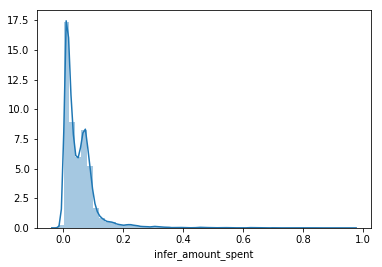

In [0]:
sns.distplot(metrics.loc[metrics['total_amount_spent']==0,'infer_amount_spent'])

metrics.loc[metrics['total_amount_spent']==0,'infer_amount_spent'].describe()

In [0]:
profit = gamma * add_rev - cost                                #유저별 기대이익 계산
profit_result.append(profit)
score = sum(profit_result)